Experiment with implementing a random zoom augmentation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

/Users/z5214005/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-21 11:36:27.189360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Preprocessing function
stddev = 0.017359
def preprocess(data):
  image = data['image']
  image = tf.clip_by_value(image, 0.0, 10.0)
  image = tf.math.asinh(image/stddev)
  return image

In [3]:
initial_dataset = (tfds.load('hsc_icl', split='train'))
dataset = initial_dataset.map(preprocess)

2023-06-21 11:37:11.014911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[22. 22. 32. 33.]


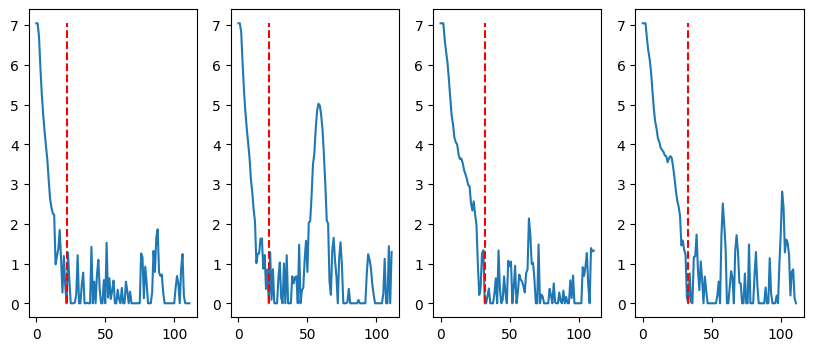

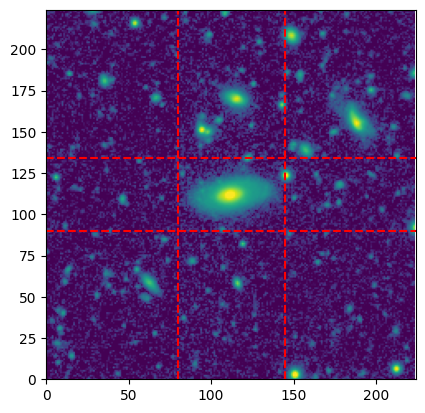

In [4]:
plt.figure(figsize=(10,4))
# Skip a random number of elements
to_skip = np.random.randint(2376)
curr = 0

for d in dataset:
    if curr < to_skip:
        curr += 1
        continue

    # Measure image profile from centre along the four cardinal directions
    img = d.numpy().squeeze()
    mid = (img.shape[0] // 2, img.shape[1] // 2)

    north = img[0:mid[0], mid[1]][::-1] # Reverse north and west so peak starts from 0
    south = img[mid[0]:, mid[1]]
    west = img[mid[0], 0:mid[1]][::-1]
    east = img[mid[0], mid[1]:]

    # Which direction has the widest peak 
    peak_widths = np.zeros((4))

    # Plot profiles
    for i,line in enumerate([north, south, west, east]):
        width = np.where(line < 0.006)[0]
        if len(width) == 0:
            width = img.shape[0]
        else:
            width = width[0]
        peak_widths[i] = width

        plt.subplot(1, 4, i+1)
        plt.plot(line)
        plt.plot([width, width], [0, max(line)], c='red', linestyle='--')
    
    print(peak_widths)

    break

plt.show()

# Show the original image with a box superimposed
plt.imshow(img)
plt.plot([0, img.shape[1]], [mid[1] - peak_widths[0], mid[1] - peak_widths[0]], c='red', linestyle='--')
plt.plot([0, img.shape[1]], [mid[1] + peak_widths[1], mid[1] + peak_widths[1]], c='red', linestyle='--')
plt.plot([mid[0] - peak_widths[2], mid[0] - peak_widths[2]], [0, img.shape[0]], c='red', linestyle='--')
plt.plot([mid[0] + peak_widths[3], mid[0] + peak_widths[3]], [0, img.shape[0]], c='red', linestyle='--')
plt.xlim(0, img.shape[1])
plt.ylim(0, img.shape[0])
plt.show()

tf.Tensor(
[1.         0.88392857 0.58035714 0.33035714 0.1875     0.66071429
 0.39285714 0.21428571 0.38392857 1.         1.         0.5625
 0.71428571 1.         0.3125     0.42857143], shape=(16,), dtype=float64)


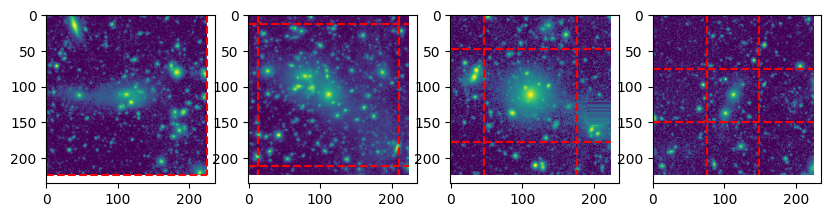

In [5]:
# Perform the calculation on the entire batch at once
batch_size = 16
initial_dataset = (tfds.load('hsc_icl', split='train')
                   .shuffle(buffer_size=1000)
                   .batch(batch_size, drop_remainder=True))

dataset = initial_dataset.map(preprocess)

for batch in dataset:
    _, height, width, _ = batch.shape

    mid = [height // 2, width // 2]

    norths = tf.reverse(batch[:, 0:mid[0], mid[1], :], axis=[1])
    souths = batch[:, mid[0]:, mid[1], :]
    wests = tf.reverse(batch[:, mid[0], 0:mid[1], :], axis=[1])
    easts = batch[:, mid[0], mid[1]:]

    max_widths = tf.ones(batch_size, dtype=tf.dtypes.int64) * 20 # Import minimum width of 40x40 box

    for lines in [norths, souths, wests, easts]:
        widths = tf.squeeze(tf.math.argmax(lines < 0.006, axis=1)) # Find half widths of peaks
        widths_fixed = tf.where(widths == 0, height // 2, widths) # If not found, default to normal size of image
        max_widths = tf.math.maximum(max_widths, widths_fixed) # Find the new maximum widths

    max_zoom = max_widths * 2 / height
    print(max_zoom)

    plt.figure(figsize=(10,4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = batch[i].numpy().squeeze()
        plt.imshow(img)
        plt.plot([0, img.shape[1]], [mid[1] - max_widths[i], mid[1] - max_widths[i]], c='red', linestyle='--')
        plt.plot([0, img.shape[1]], [mid[1] + max_widths[i], mid[1] + max_widths[i]], c='red', linestyle='--')
        plt.plot([mid[0] - max_widths[i], mid[0] - max_widths[i]], [0, img.shape[0]], c='red', linestyle='--')
        plt.plot([mid[0] + max_widths[i], mid[0] + max_widths[i]], [0, img.shape[0]], c='red', linestyle='--')

    plt.show()
    break


Implement an augmentation to do a radial shuffle (shuffle pixels but keeping them all the same distance from the centre as before the shuffle)

In [6]:
for batch in dataset:
    img = batch[0]
    break

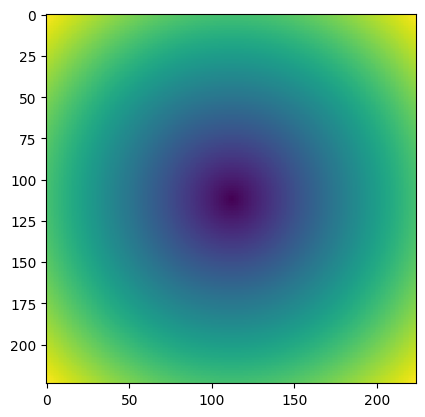

In [7]:
# Create a distance map
centre = (img.shape[1] // 2, img.shape[0] // 2)
Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
dist_map = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)
plt.imshow(dist_map, interpolation='none')
plt.show()

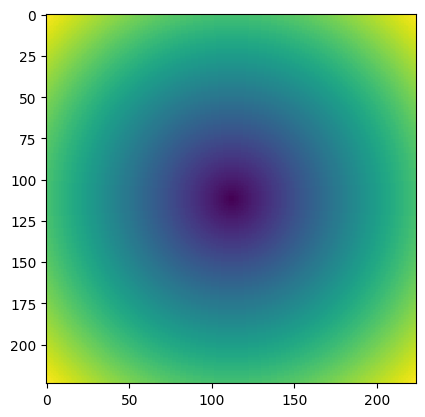

array([[158, 158, 157, ..., 156, 157, 158],
       [158, 157, 156, ..., 156, 156, 157],
       [157, 156, 156, ..., 155, 156, 156],
       ...,
       [156, 156, 155, ..., 154, 155, 156],
       [157, 156, 156, ..., 155, 156, 156],
       [158, 157, 156, ..., 156, 156, 157]])

In [8]:
# Round the distance map
dist_map_int = np.round(dist_map).astype(int)
plt.imshow(np.round(dist_map), interpolation='none')
plt.show()
dist_map_int

In [9]:
# Project the original image into polar coordinates, filling with NaNs where necessary

# Create an array big enough to contain the image
num_rows = dist_map_int[0][0] + 1 # Maximum r in the image

dists, counts = np.unique(dist_map_int, return_counts = True) # Count number of occurrences of each int radius

num_cols = np.max(counts)

pol_arr = np.full([num_rows, num_cols], fill_value=np.nan)
print(num_rows, num_cols)

159 720


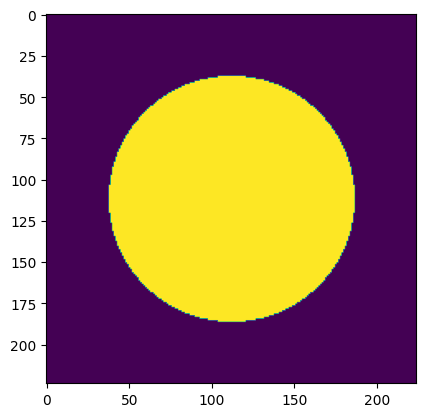

In [10]:
# Create a really basic image to test this on
circle = dist_map_int < 75
plt.imshow(circle)
plt.show()

In [11]:
# Compute the indices for the angle axis just with a for loop
# What I want is to be able to go pol_arr[coordinates] = img
ax2_indices = np.full(dist_map.shape, np.nan)
for dist in range(num_rows):
    ax2_indices[dist_map_int == dist] = np.arange(counts[dist]) # These are the indices for axis 2
ax2_indices = ax2_indices.astype(int)
print(ax2_indices)
print(np.max(ax2_indices))

[[ 0  1  0 ...  3  1  2]
 [ 3  2  4 ...  6  7  3]
 [ 4  8  9 ...  5 10 11]
 ...
 [17 18 14 ... 23 15 19]
 [ 5 20 21 ... 17 22 23]
 [ 4  6 24 ... 26 27  7]]
719


In [12]:
print(ax2_indices[dist_map_int == 110])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

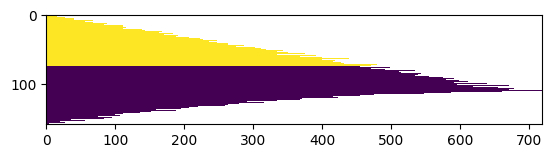

In [13]:
pol_arr[:,:] = np.nan
pol_arr[dist_map_int, ax2_indices] = circle
plt.imshow(pol_arr, interpolation='none')
plt.show()

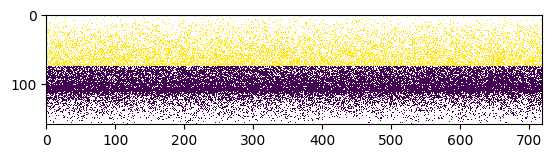

In [14]:
# Now we shuffle along the second axis only
rng = np.random.default_rng()
pol_arr_shuffled = rng.permuted(pol_arr, axis=1)
plt.imshow(pol_arr_shuffled, interpolation='none')
plt.show()

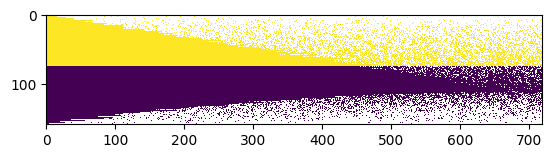

In [15]:
# Move all the nans back to the ends of rows
mask = np.isnan(pol_arr_shuffled)
# nan_pos = np.sort(mask) # Don't really need this, since we don't care if stuff gets left in nan positions
not_nan_pos = np.sort(~mask)[:,::-1]
pol_arr_shuffled[not_nan_pos] = pol_arr_shuffled[~mask]
# pol_arr_shuffled[nan_pos] = np.nan

plt.imshow(pol_arr_shuffled, interpolation='none')
plt.show()

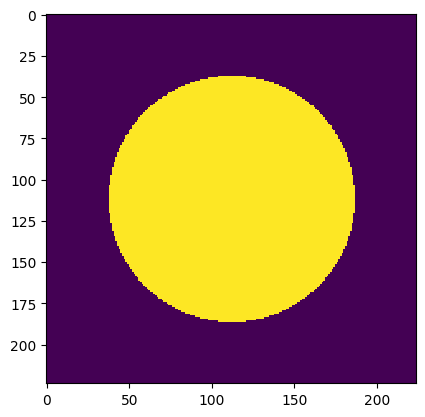

In [16]:
# Now transform the pixels back to cartesian view - fill with nans so we can see if anything weird happens
circle_new = np.full(circle.shape, np.nan)
circle_new = pol_arr_shuffled[dist_map_int, ax2_indices]

plt.imshow(circle_new, interpolation='none')
plt.show()

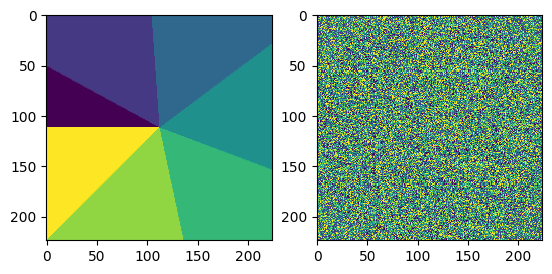

In [17]:
# Now try with an image that does vary radially
radial_image = np.round((np.arctan2(Y-centre[1], X-centre[0]) + np.pi)) # 0 to 2pi instead of -pi to pi

pol_arr[:,:] = np.nan
pol_arr[dist_map_int, ax2_indices] = radial_image

# Now we shuffle along the second axis only
pol_arr_shuffled = rng.permuted(pol_arr, axis=1)

mask = np.isnan(pol_arr_shuffled)
not_nan_pos = np.sort(~mask)[:,::-1]
pol_arr_shuffled[not_nan_pos] = pol_arr_shuffled[~mask]

img_new = np.full(radial_image.shape, np.nan)
img_new = pol_arr_shuffled[dist_map_int, ax2_indices]

plt.subplot(121)
plt.imshow(radial_image)
plt.subplot(122)
plt.imshow(img_new, interpolation='none')
plt.show()

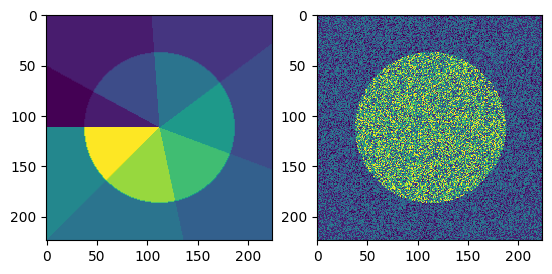

In [18]:
# Finally, try with an image that has both radially invariant and radially variant features
radial_image = (np.round((np.arctan2(Y-centre[1], X-centre[0]) + np.pi)) + 1) * 2*(circle+1) # 0 to 2pi instead of -pi to pi

pol_arr[:,:] = np.nan
pol_arr[dist_map_int, ax2_indices] = radial_image

# Now we shuffle along the second axis only
pol_arr_shuffled = rng.permuted(pol_arr, axis=1)

mask = np.isnan(pol_arr_shuffled)
not_nan_pos = np.sort(~mask)[:,::-1]
pol_arr_shuffled[not_nan_pos] = pol_arr_shuffled[~mask]

img_new = np.full(radial_image.shape, np.nan)
img_new = pol_arr_shuffled[dist_map_int, ax2_indices]

plt.subplot(121)
plt.imshow(radial_image)
plt.subplot(122)
plt.imshow(img_new, interpolation='none')
plt.show()

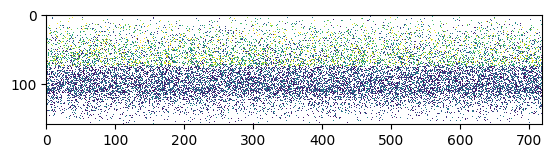

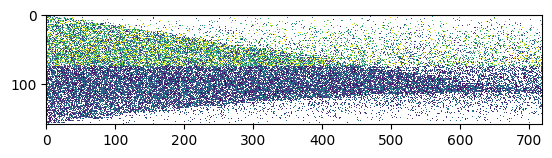

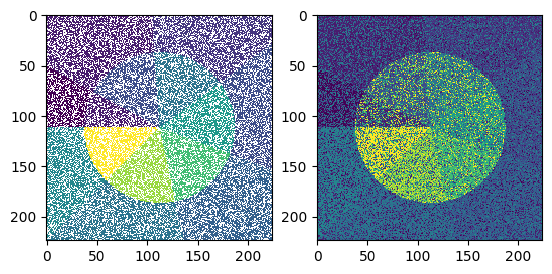

In [19]:
# Now, try only shuffling 50% of the pixels 
# Randomly mask out 50% of the image
img_masked = radial_image.copy()
len_of_selection = (img.shape[0] * img.shape[1]) // 2
random_coords = tf.random.uniform((2, len_of_selection), maxval=img.shape[0], dtype=tf.dtypes.int32).numpy()
img_masked[random_coords[0], random_coords[1]] = np.nan

pol_arr[:,:] = np.nan
dists_masked = dist_map_int[~np.isnan(img_masked)]
ax2_masked = ax2_indices[~np.isnan(img_masked)]

pol_arr[dists_masked, ax2_masked] = img_masked[~np.isnan(img_masked)]

# Now we shuffle along the second axis only
pol_arr_shuffled = rng.permuted(pol_arr, axis=1)

plt.imshow(pol_arr_shuffled, interpolation='none')
plt.show()

nan_mask = np.isnan(pol_arr_shuffled)
# Place the not nan values back where we expect to find them
sorted_inds = np.argsort(dists_masked)

pol_arr_shuffled[dists_masked[sorted_inds], ax2_masked[sorted_inds]] = pol_arr_shuffled[~nan_mask]
plt.imshow(pol_arr_shuffled, interpolation='none')
plt.show()

# Create the final image
img_new = np.full(radial_image.shape, np.nan)
img_new[~np.isnan(img_masked)] = pol_arr_shuffled[dists_masked, ax2_masked]
img_new[np.isnan(img_masked)] = radial_image[np.isnan(img_masked)] # Replace the initially masked values

plt.subplot(121)
plt.imshow(img_masked, interpolation='none')
plt.subplot(122)
plt.imshow(img_new, interpolation='none')
plt.show()

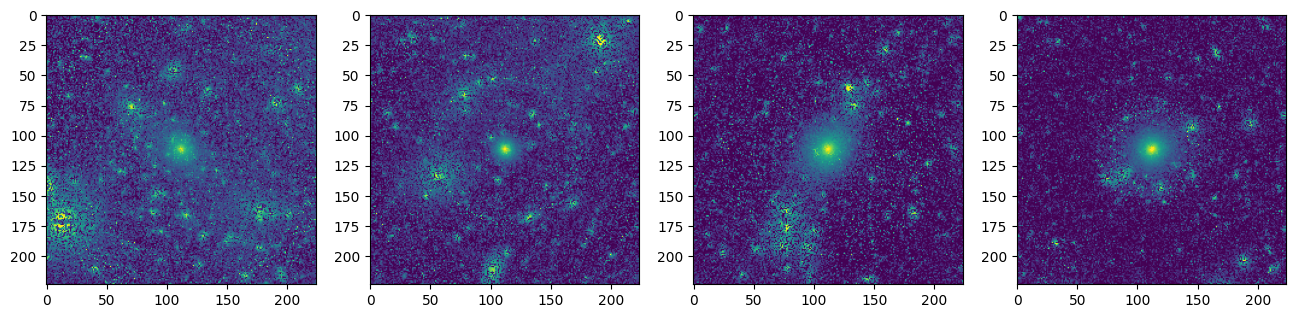

In [34]:
# Turn this into a tensorflow operation

# This stuff will be precomputed
shuffle_fraction = 0.5
input_shape=(224, 224, 1)
height = input_shape[0]
width = input_shape[1]
rng = np.random.default_rng()

# Precomputations
centre = (input_shape[0] // 2, input_shape[1] // 2)
Y, X = np.ogrid[:224, :224]
# Prepare the radial and angle maps
dist_map = tf.convert_to_tensor(np.round(np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)).astype(int))
ax2_indices = np.zeros(dist_map.shape)
num_rows = dist_map[0][0] + 1
dists, counts = np.unique(dist_map, return_counts = True)
for dist in range(num_rows):
    ax2_indices[dist_map == dist] = np.arange(counts[dist]) # These are the 'angle' indices
num_cols = np.max(counts)
ax2_indices = tf.convert_to_tensor(ax2_indices.astype(int))

@tf.function
def pyfunc(image):
        # Select `shuffle fraction`` random coordinates
        random_px = tf.random.uniform(image.shape) < shuffle_fraction
        masked_img = tf.squeeze(tf.where(random_px == True, image, np.nan))

        # Insert valid values into the polar projection
        dists_masked = dist_map[~tf.math.is_nan(masked_img)]
        ax2_masked = ax2_indices[~tf.math.is_nan(masked_img)]

        cart_to_pol_ind = tf.stack([dists_masked, ax2_masked], axis=1)
        polar_array = tf.fill((num_rows, num_cols), value=np.nan)
        polar_array = tf.tensor_scatter_nd_update(polar_array, indices=cart_to_pol_ind, updates=masked_img[~tf.math.is_nan(masked_img)])

        # Shuffle along the second axis. Code from https://stackoverflow.com/a/74870471
        rnd = tf.argsort(tf.random.uniform(polar_array.shape), axis=1)
        rnd = tf.concat([tf.repeat(tf.range(polar_array.shape[0])[...,tf.newaxis,tf.newaxis],tf.shape(rnd)[1],axis=1),rnd[...,tf.newaxis]],axis=2)
        pol_arr_shuffled = tf.gather_nd(polar_array, rnd, batch_dims=0)
        
        # Place the not nan values back where we expect to find them
        nan_mask = tf.math.is_nan(pol_arr_shuffled)
        sorted_inds = tf.argsort(dists_masked)
        dists_sorted = tf.gather(dists_masked, sorted_inds)
        ax2_sorted = tf.gather(ax2_masked, sorted_inds)
        by_row_inds = tf.stack([dists_sorted, ax2_sorted], axis=1)
        pol_arr_shuffled = tf.tensor_scatter_nd_update(pol_arr_shuffled, indices=by_row_inds, updates = pol_arr_shuffled[~nan_mask])
        
        # Create the final image
        vals_to_insert = tf.gather_nd(pol_arr_shuffled, cart_to_pol_ind)
        image = tf.squeeze(image)
        image = tf.tensor_scatter_nd_update(image, indices=tf.reshape(tf.where(~tf.math.is_nan(masked_img)), [-1, 2]), updates=vals_to_insert)
        image = tf.expand_dims(image, 2)
        return image

for batch in dataset:
    batch = tf.map_fn(pyfunc, batch)

    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(batch[0])
    plt.subplot(142)
    plt.imshow(batch[1])
    plt.subplot(143)
    plt.imshow(batch[2])
    plt.subplot(144)
    plt.imshow(batch[3])
    plt.show()
    break

In [21]:
def stupid_way(image):
    # Mask out shuffle_fraction of the image
    random_px = tf.random.uniform(image.shape) < shuffle_fraction
    masked_img = tf.squeeze(tf.where(random_px == True, np.nan, image))
    res = tf.zeros_like(image)
    for r in range(height):
        # Select valid indices and get values
        indices = tf.where((dist_map == r) & (~tf.math.is_nan(masked_img)))
        vals = tf.gather_nd(image, indices)
        
        # Shuffle the values
        vals_shuffled = tf.random.shuffle(vals)
        
        # Put the new values into the results array 

        
        

for batch in dataset:
    tf.map_fn(stupid_way, batch)
    break

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
# Turn this into a batched tensorflow operation

# This stuff will be precomputed
centre = (224 // 2, 224 // 2)
Y, X = np.ogrid[:224, :224]
dist_map = np.round(np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)).astype(int)
ax2_indices = np.zeros(dist_map.shape)
for dist in range(num_rows):
    ax2_indices[dist_map_int == dist] = np.arange(counts[dist]) # These are the indices for axis 2
ax2_indices = ax2_indices.astype(int)

shuffle_percentage = 50

num_rows = dist_map[0][0] + 1 # Maximum r in the image

dists, counts = np.unique(dist_map, return_counts = True) # Count number of occurrences of each int radius

num_cols = np.max(counts)

for batch in dataset:
    # Create a masked version of the batch
    batch_size = batch.shape[0]
    height = batch.shape[1]
    width = batch.shape[2]
    # Select random coordinates for all images in the batch
    len_of_selection = (height * width) // 2
    random_coords = tf.random.uniform((2, len_of_selection * batch_size), maxval=height, dtype=tf.dtypes.int32).numpy()
    batches = tf.repeat(tf.range(batch_size), len_of_selection)[tf.newaxis, :].numpy()
    random_coords = tf.concat([batches, random_coords], axis=0).numpy()

    # Mask the images
    imgs_masked = tf.squeeze(tf.identity(batch)).numpy() # Don't need to copy in the actual augmentation, but just to see what's going on
    imgs_masked[random_coords[0], random_coords[1], random_coords[2]] = np.nan

    # Create the array for polar projection
    polar_array = np.full((batch_size, num_rows, num_cols), np.nan)
    # Only use the pixels which are not nan
    dist_maps = tf.repeat(dist_map[tf.newaxis, :], batch_size, axis=0)
    ax2_indicess = tf.repeat(ax2_indices[tf.newaxis, :], batch_size, axis=0)
    dists_masked = dist_maps[~tf.math.is_nan(imgs_masked)]
    ax2_masked = ax2_indicess[~tf.math.is_nan(imgs_masked)]
    batches = tf.repeat(tf.range(batch_size), height * width)
    batches_masked = batches[~np.isnan(imgs_masked).flatten()]

    polar_array[batches_masked, dists_masked, ax2_masked] = imgs_masked[~np.isnan(imgs_masked)]

    # Shuffle along the second (angle) axis only. Adapted from https://stackoverflow.com/questions/39875674/is-there-a-built-in-function-in-tensorflow-for-shuffling-or-permutating-tensors with an extra axis
    rnd = tf.argsort(tf.random.uniform(polar_array.shape), axis=2) # Random indices for each element in each row
    row_ind = tf.repeat(tf.range(num_rows, dtype=tf.dtypes.int32)[...,tf.newaxis,tf.newaxis], num_cols, axis=1) # Indexing rows in one image
    all_row_ind = tf.repeat(row_ind[tf.newaxis,:], rnd.shape[0], axis=0) # Indexing rows in all images
    batch_ind = tf.reshape(tf.repeat(tf.range(batch_size), num_rows * num_cols), (batch_size, num_rows, num_cols, 1)) # Indexing every element in each batch
    rnd_ind = tf.concat([batch_ind, all_row_ind, rnd[...,tf.newaxis]], axis=-1) # Create final indices
    pol_arr_shuffled = tf.gather_nd(polar_array, rnd_ind, batch_dims=0).numpy() # Do the final shuffle

    # Place the not nan values back where we expect to find them
    nan_mask = tf.math.is_nan(pol_arr_shuffled)
    sorted_inds = tf.argsort(dists_masked)
    pol_arr_shuffled[dists_masked[sorted_inds], ax2_masked[sorted_inds]] = pol_arr_shuffled[~nan_mask]

    # Create the final images
    imgs_new = tf.fill(batch.shape, np.nan) # Don't need to create new images in the actual augmentation
    imgs_new[~tf.math.is_nan(imgs_masked)] = pol_arr_shuffled[dists_masked, ax2_masked]
    imgs_new[tf.math.is_nan(imgs_masked)] = batch[np.isnan(img_masked)]

    # Display some of the final images
    plt.figure(figsize=(10,4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = batch[i].numpy().squeeze()
        plt.imshow(img)
    plt.show()

    plt.figure(figsize=(10,4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = imgs_new[i].numpy().squeeze()
        plt.imshow(img)
    plt.show()
    break

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 76089, 380269, 106466, ..., 395586,  91407,      0])